In [223]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

In [224]:
fetch_df = pd.read_csv('interesting_genes.bed', sep='\t', header=None, names=['chr', 'start', 'stop', 'gene'])

In [225]:
#pysam.index("../WES-normal.bam")

In [226]:
samfile = pysam.AlignmentFile('../WES-normal.bam', 'rb')
genes_bam = pysam.AlignmentFile('../genes.bam', 'wb', template=samfile)

i = 0
d = []

for index, gene in fetch_df.iterrows():
    #print(gene['gene'])
    for read in samfile.fetch(gene['chr'], gene['start'] - 20000, gene['stop'] + 20000):
        genes_bam.write(read)
        if i < 21:
            #print(read)
            i+=1
    for pileupcolumn in samfile.pileup(gene['chr'], gene['start'] - 20000, gene['stop'] + 20000):
        d.append(
                {
                    'Position': pileupcolumn.pos,
                    'Read Count': pileupcolumn.n,
                    'Chromosome': gene['chr'],
                    'Gene': gene['gene']
                }
            )

df_normal = pd.DataFrame(d)


genes_bam.close()
samfile.close()

In [227]:
#pysam.index("../WES-tumor.bam")

In [228]:
samfile = pysam.AlignmentFile('../WES-tumor.bam', 'rb')
genes_bam = pysam.AlignmentFile('../genes_tumor.bam', 'wb', template=samfile)

d = []

for index, gene in fetch_df.iterrows():
    for read in samfile.fetch(gene['chr'], gene['start'] - 20000, gene['stop'] + 20000):
        genes_bam.write(read)
    
    for pileupcolumn in samfile.pileup(gene['chr'], gene['start'] - 20000, gene['stop'] + 20000):
            d.append(
                {
                    'Position': pileupcolumn.pos,
                    'Read Count': pileupcolumn.n,
                    'Chromosome': gene['chr'],
                    'Gene': gene['gene']
                }
            )

df_tumor = pd.DataFrame(d)

genes_bam.close()
samfile.close()

In [229]:
df_tumor.drop_duplicates(subset=['Position'], inplace = True)
df_normal.drop_duplicates(subset=['Position'], inplace = True)

In [230]:
df_tumor.pivot_table(columns=['Position'], aggfunc='size')[df_tumor.pivot_table(columns=['Position'], aggfunc='size')>1]

Series([], dtype: int64)

In [231]:
df_normal.pivot_table(columns=['Position'], aggfunc='size')[df_normal.pivot_table(columns=['Position'], aggfunc='size')>1]

Series([], dtype: int64)

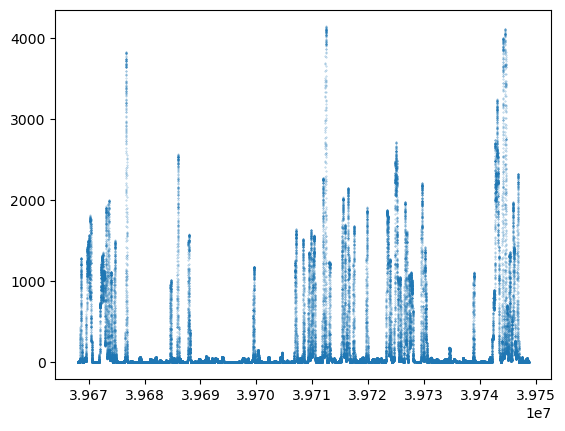

In [232]:
plt.scatter(df_tumor[df_tumor['Gene'] == 'ERBB2']['Position'], df_tumor[df_tumor['Gene'] == 'ERBB2']['Read Count'], alpha=0.5, s=0.1)

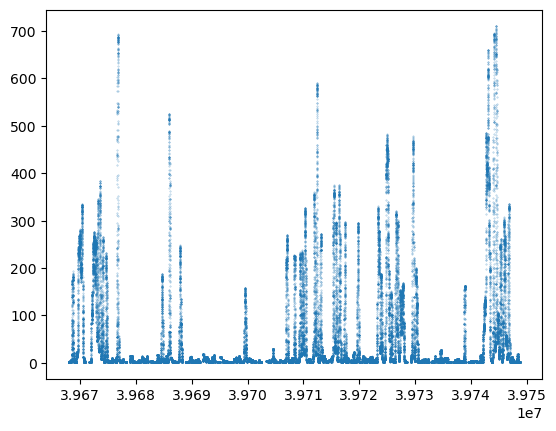

In [233]:
plt.scatter(df_normal[df_normal['Gene'] == 'ERBB2']['Position'], df_normal[df_normal['Gene'] == 'ERBB2']['Read Count'], alpha=0.5, s=0.1)

In [234]:
df_total = df_tumor.merge(df_normal, left_on='Position', right_on='Position',
          suffixes=('_tumor', '_normal'), how='outer')

In [235]:
df_total['depth_ratio'] = np.log2(df_total['Read Count_tumor'] / df_total['Read Count_normal'])

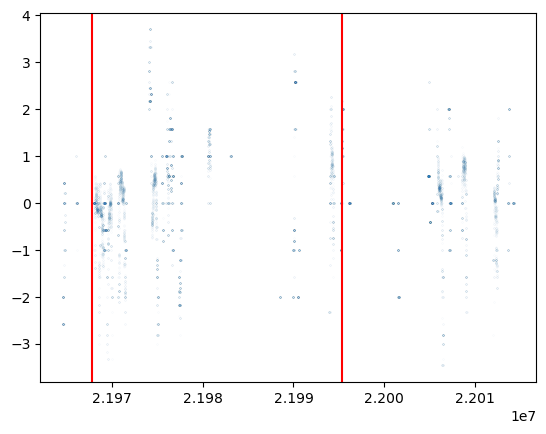

In [236]:
target_gene = 'CDKN2A'
plt.scatter(df_total[df_total['Gene_tumor'] == target_gene]['Position'], df_total[df_total['Gene_tumor'] == target_gene]['depth_ratio'], alpha=0.5, s=0.001)
plt.axvline(x = fetch_df[fetch_df['gene'] == target_gene]['start'].iloc[0], color = 'r')
plt.axvline(x = fetch_df[fetch_df['gene'] == target_gene]['stop'].iloc[0], color = 'r')

In [146]:
#bin_size = 5000
#bins = np.concatenate([([i]*bin_size) for i in range(ceil(df_total.shape[0] / bin_size))], axis=0)[:df_total.shape[0]]
#df_total['bin'] = bins

In [147]:
#df_total

In [148]:
#df_group = df_total[['Position', 'depth_ratio', 'bin']].groupby(['bin'])['depth_ratio'].median()

In [149]:
#df_group

In [150]:
#df_group = df_group.reset_index() 
#df_group

In [151]:
#for bin in bins:
#    df_total['median_binning_depth_ratio'] = np.nan
#    df_total.loc[df_total['bin'] == bin, 'median_depth_ratio'] = df_group[df_group['bin'] == bin]['depth_ratio']

In [152]:
#df_total

In [273]:
df_total['median_rolling_depth_ratio'] = df_total['depth_ratio'].rolling(1000, min_periods=1).median(skipna=False) 

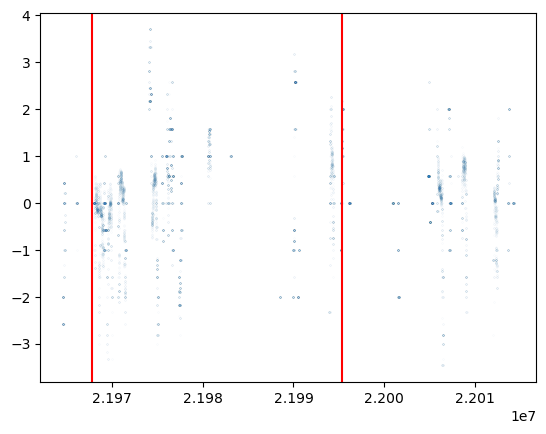

In [274]:
target_gene = 'CDKN2A'
plt.scatter(df_total[df_total['Gene_tumor'] == target_gene]['Position'], df_total[df_total['Gene_tumor'] == target_gene]['depth_ratio'], alpha=0.5, s=0.001)
plt.axvline(x = fetch_df[fetch_df['gene'] == target_gene]['start'].iloc[0], color = 'r')
plt.axvline(x = fetch_df[fetch_df['gene'] == target_gene]['stop'].iloc[0], color = 'r')

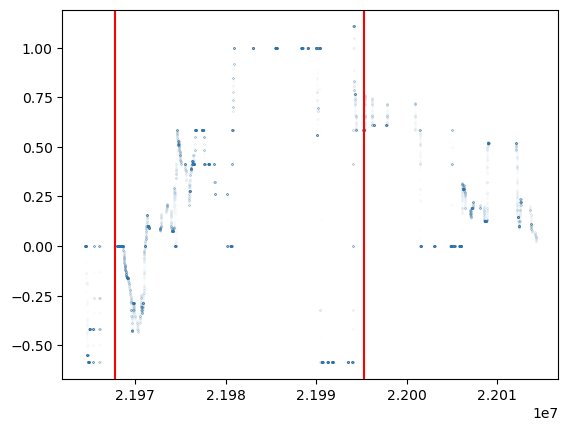

In [275]:
plt.scatter(df_total[df_total['Gene_tumor'] == target_gene]['Position'], df_total[df_total['Gene_tumor'] == target_gene]['median_rolling_depth_ratio'], alpha=0.5, s=0.001)
plt.axvline(x = fetch_df[fetch_df['gene'] == target_gene]['start'].iloc[0], color = 'r')
plt.axvline(x = fetch_df[fetch_df['gene'] == target_gene]['stop'].iloc[0], color = 'r')

In [272]:
df_total.head(9000)

,Position,Read Count_tumor,Chromosome_tumor,Gene_tumor,Read Count_normal,Chromosome_normal,Gene_normal,depth_ratio,median_rolling_depth_ratio
0,39668046,1.0,chr17,ERBB2,2.0,chr17,ERBB2,-1.000000,-1.000000
1,39668047,1.0,chr17,ERBB2,2.0,chr17,ERBB2,-1.000000,-1.000000
2,39668048,1.0,chr17,ERBB2,2.0,chr17,ERBB2,-1.000000,-1.000000
3,39668049,1.0,chr17,ERBB2,2.0,chr17,ERBB2,-1.000000,-1.000000
4,39668050,1.0,chr17,ERBB2,2.0,chr17,ERBB2,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...
8995,39677654,20.0,chr17,ERBB2,6.0,chr17,ERBB2,1.736966,1.584963
8996,39677655,19.0,chr17,ERBB2,6.0,chr17,ERBB2,1.662965,1.584963
8997,39677656,19.0,chr17,ERBB2,6.0,chr17,ERBB2,1.662965,1.584963
8998,39677657,19.0,chr17,ERBB2,6.0,chr17,ERBB2,1.662965,1.584963
